# Building a Neural Net using AutoDiff
In this notebook, we demostrate the use of our AutoDiff package. We implement a Neural Network, with a single hidden layer, with the Sigmoid activation function. We implement forward and backward passes for the Network, and train it using Stochastic Gradient descent with a batch size of 1. All gradient computations required for training this Neural Net have been implemented using our AutoDiff package.

For demonstration, we train a Neural Net (with 10 nodes in the hidden layer) on synthetic data generated using the function $f(x) = sin(x^2)$. We then compute the predictions on our Test Set (which is also generated using $f(x)$), and plot the truth value and prediction.

In [410]:
from AutoDiff import DiffObj, Variable, Constant
from AutoDiff import MathOps as mo
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [563]:
class NeuralNet(object):
    def __init__(self, input_dim, hidden_dim, out_dim, lr=0.1):
        self.in_var, self.in_val = self.DeclareVariables('x', (1, input_dim+1))
        self.hid_wt_var, self.hid_wt_val = self.DeclareVariables('w', (hidden_dim, input_dim+1))
        self.hid_function = self.AffineLayer(self.in_var[0].values(), self.hid_wt_var, \
                                             activation=True)
        self.hid_var, self.hid_val = self.DeclareVariables('h', (1, hidden_dim))
        self.out_wt_var, self.out_wt_val = self.DeclareVariables('v', (out_dim, hidden_dim))
        self.out_function = self.AffineLayer(self.hid_var[0].values(), self.out_wt_var)
        self.out_var, self.out_val = self.DeclareVariables('z', (1, out_dim))
        self.out_true_var, self.out_true_val = self.DeclareVariables('y', (out_dim, 1))
        self.loss = self.GetLoss('l2')
        self.lr = lr
    
    @classmethod
    def Sigmoid(cls, x):
        return 1/(1 + mo.exp(-x))
    
    def DeclareVariables(self, base_name, dim):
        var = [{base_name + '_' + str(i+1) + ('_' + str(j+1) if dim[1] > 1 else '') : \
               Variable(base_name + '_' + str(i+1) + ('_' + str(j+1) if dim[1] > 1 else '')) \
               for j in range(dim[1])} for i in range(dim[0])]
        val_dict = [{base_name + '_' + str(i+1) + ('_' + str(j+1) if dim[1] > 1 else '') : np.random.randn()\
               for j in range(dim[1])} for i in range(dim[0])]
        return var, val_dict
    
    def AffineLayer(self, in_obj, wt_var, activation=False):
        layer_out = [None]*len(wt_var)
        for idx, node_wt in enumerate(wt_var):
            layer_out[idx] = sum(a*b for a,b in zip(in_obj, node_wt.values()))
            if activation:
                layer_out[idx] = NeuralNet.Sigmoid(layer_out[idx])
        return layer_out
    
    def UpdateParams(self, wt_val, grad):
        for w, dw in zip(wt_val, grad):
            new_w = np.asarray(list(w.values())) - self.lr*np.asarray(dw)
            w.update(zip(w.keys(), new_w))
    
    def GetLoss(self, loss_fn='l2'):
        loss_obj = None
        if loss_fn == 'l2':
            loss_obj = sum((a - b)**2 for a,b in zip(self.out_true_var[0].values(), \
                                              self.out_var[0].values()))
        return loss_obj
    
    def forward(self, X, y):
        X_with_bias = np.array([1] + list(X))
        self.in_val[0].update(zip(self.in_val[0].keys(), X_with_bias))
        hid_vals = []
        for idx, hid_wt in enumerate(self.hid_wt_val):
            val_dict = {**self.in_val[0], **hid_wt}
            hid_vals += [self.hid_function[idx].get_val(val_dict)]
        self.hid_val[0].update(zip(self.hid_val[0].keys(), hid_vals))
        out_vals = []
        for idx, out_wt in enumerate(self.out_wt_val):
            val_dict = {**self.hid_val[0], **out_wt}
            out_vals += [self.out_function[idx].get_val(val_dict)]
        self.out_val[0].update(zip(self.out_val[0].keys(), out_vals))
        self.out_true_val[0].update(zip(self.out_true_val[0].keys(), [y]))
        val_dict = {**self.out_val[0], **self.out_true_val[0]}
        loss = self.loss.get_val(val_dict)
        return loss, self.out_val[0].values()
        
    def backward(self):
        val_dict = {**self.out_val[0], **self.out_true_val[0]}
        dLdz = self.loss.get_der(val_dict, with_respect_to=self.out_val[0].keys())
        dzdv, dzdh = [], []
        for idx, out_wt in enumerate(self.out_wt_val):
            val_dict = {**self.hid_val[0], **out_wt}
            dzdv += [self.out_function[idx].get_der(val_dict, \
                                                 with_respect_to=out_wt.keys())]
            dzdh += [self.out_function[idx].get_der(val_dict, \
                                                 with_respect_to=self.hid_val[0].keys())]
        dLdv =  [list(dLdz.values())[0]*np.asarray(list(dzdv[0].values()))]
        dLdh =  list(dLdz.values())[0]*np.asarray(list(dzdh[0].values()))[:, np.newaxis]
        dhdw = []
        for idx, hid_wt in enumerate(self.hid_wt_val):
            val_dict = {**self.in_val[0], **hid_wt}
            dhdw += [list(self.hid_function[idx].get_der(val_dict, \
                                                   with_respect_to=hid_wt.keys()).values())]
        dhdw = np.asarray(dhdw)
        dLdw = dLdh*dhdw
        self.UpdateParams(self.out_wt_val, dLdv)
        self.UpdateParams(self.hid_wt_val, dLdw)

In [575]:
# Demonstration of Neural Network
input_dim = 1
hidden_dim = 10
out_dim = 1
lr = 0.1
nn = NeuralNet(input_dim, hidden_dim, out_dim, lr)

X_data = np.random.randn(3000, input_dim)
y_data = np.sin(np.multiply(X_data, X_data))
num_train = 2700
X_train, y_train = X_data[0:num_train,:], y_data[0:num_train]
X_test, y_test = X_data[num_train:,:], y_data[num_train:]

In [576]:
num_epochs = 50
tol = 1e-4
prev_loss = 1e6
for epoch in range(num_epochs):
    running_loss = 0
    for i in range(X_train.shape[0]):
        loss, _ = nn.forward(X_train[i,:], y_train[i])
        running_loss += loss[0]
        nn.backward()
    print('Loss after epoch {} is: {:.4f}'.format(epoch + 1, running_loss))
    if abs(running_loss - prev_loss) < tol:
        print('Training converged, stopping early.')
        break
    prev_loss = running_loss

Loss after epoch 1 is: 559.2320
Loss after epoch 2 is: 326.6563
Loss after epoch 3 is: 209.9506
Loss after epoch 4 is: 157.7693
Loss after epoch 5 is: 119.8534
Loss after epoch 6 is: 98.6866
Loss after epoch 7 is: 87.4364
Loss after epoch 8 is: 80.7141
Loss after epoch 9 is: 76.2738
Loss after epoch 10 is: 73.1023
Loss after epoch 11 is: 70.6752
Loss after epoch 12 is: 68.6997
Loss after epoch 13 is: 67.0020
Loss after epoch 14 is: 65.4715
Loss after epoch 15 is: 64.0328
Loss after epoch 16 is: 62.6321
Loss after epoch 17 is: 61.2354
Loss after epoch 18 is: 59.8350
Loss after epoch 19 is: 58.4585
Loss after epoch 20 is: 57.1644
Loss after epoch 21 is: 56.0177
Loss after epoch 22 is: 55.0537
Loss after epoch 23 is: 54.2613
Loss after epoch 24 is: 53.5997
Loss after epoch 25 is: 53.0221
Loss after epoch 26 is: 52.4897
Loss after epoch 27 is: 51.9755
Loss after epoch 28 is: 51.4629
Loss after epoch 29 is: 50.9430
Loss after epoch 30 is: 50.4126
Loss after epoch 31 is: 49.8730
Loss after e

In [577]:
# Test on the test set
y_pred = [0.0]*len(y_train)
for i in range(len(y_train)):
    _, pred = nn.forward(X_train[i,:], y_train[i])
    y_pred[i] = list(pred)[0]

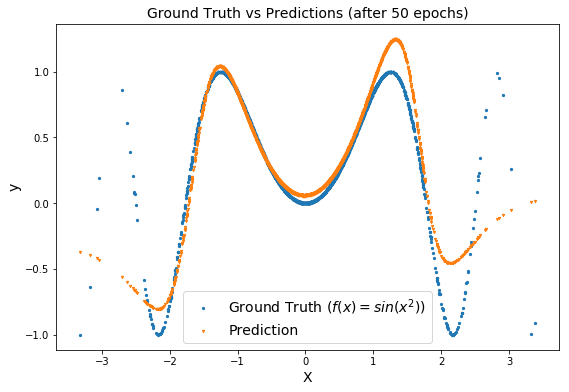

In [579]:
fig = plt.gcf()
fig.set_size_inches(9, 6)
_ = plt.scatter(X_train[:,0], y_train, marker='o', s=5, label=r'Ground Truth ($f(x) = sin(x^2)$)')
_ = plt.scatter(X_train[:,0], y_pred, marker='v', s=5, label='Prediction')
_ = plt.xlabel('X', fontsize=14)
_ = plt.ylabel('y', fontsize=14)
_ = plt.legend(loc='best', fontsize=14)
_ = plt.title('Ground Truth vs Predictions (after {} epochs)'.format(num_epochs), fontsize=14)